## Importing necessary libraries and notebooks

In [33]:
import xarray as xr
import sys
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import netCDF4 as nc
import numpy as np
import opyf

script_path = "/home/yahia/Documents/Jupyter/Sargassum"
if script_path not in sys.path:
    sys.path.append(script_path)
from vii_Flow_NetCDF import save_flow
from vii_Flow_Analysis import haversine

## Two images (NetCDF)

### *calculate_opyflow*

In [34]:
def calculate_opyflow(nc_file1, nc_file2, variable_key="fai_anomaly", time_interval=86400):
    # Load data from NetCDF files
    data1 = xr.open_dataset(nc_file1)
    data2 = xr.open_dataset(nc_file2)
    img1 = data1[variable_key].values
    img2 = data2[variable_key].values

    # Ensure data is 2D
    if img1.ndim == 3:
        img1 = img1[0]
    if img2.ndim == 3:
        img2 = img2[0]

    # Normalize and convert to 8-bit grayscale
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Initialize the opyf analyzer and set the images
    analyzer = opyf.frameSequenceAnalyzer()
    analyzer.set_images([img1, img2])

    # Extract features and calculate displacements using OpyFlow
    flow_vectors = analyzer.extractGoodFeaturesAndDisplacements()

    # Get latitude and longitude values
    latitudes = data1.latitude.values
    longitudes = data1.longitude.values

    # Calculate consistent distances between consecutive latitudes and longitudes
    d_lat_m = haversine(longitudes[0], latitudes[0], longitudes[0], latitudes[1]) * 1000
    d_lon_m = haversine(longitudes[0], latitudes[0], longitudes[1], latitudes[0]) * 1000

    # Convert pixel flow to real-world distance flow in meters per second
    flow_u_mps = flow_vectors[..., 0] * (d_lon_m / time_interval)
    flow_v_mps = flow_vectors[..., 1] * (d_lat_m / time_interval)

    return flow_u_mps, flow_v_mps  # Return flow in meters per second

### *calculate_opyflow_with_temp_files*

In [44]:
def calculate_opyflow_with_temp_files(nc_file1, nc_file2, variable_key="fai_anomaly", time_interval=86400, lat_range=None, lon_range=None):
    # Load NetCDF files
    data1 = xr.open_dataset(nc_file1)
    data2 = xr.open_dataset(nc_file2)

    # Apply geographic slicing if ranges are provided
    if lat_range and 'latitude' in data1.coords:
        data1 = data1.sel(latitude=slice(*lat_range))
    if lon_range and 'longitude' in data1.coords:
        data1 = data1.sel(longitude=slice(*lon_range))
    if lat_range and 'latitude' in data2.coords:
        data2 = data2.sel(latitude=slice(*lat_range))
    if lon_range and 'longitude' in data2.coords:
        data2 = data2.sel(longitude=slice(*lon_range))

    img1 = data1[variable_key].values
    img2 = data2[variable_key].values

    # Preprocess images
    if img1.ndim == 3:
        img1 = img1[0]
    if img2.ndim == 3:
        img2 = img2[0]

    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Flip images vertically to correct orientation
    img1 = cv2.flip(img1, 0)
    img2 = cv2.flip(img2, 0)

    # Create temporary directory for images
    with tempfile.TemporaryDirectory() as temp_dir:
        cv2.imwrite(os.path.join(temp_dir, 'img1.png'), img1)
        cv2.imwrite(os.path.join(temp_dir, 'img2.png'), img2)

        # Setup the analyzer
        analyzer = opyf.frameSequenceAnalyzer(temp_dir)
        analyzer.set_vecTime(starting_frame=0, step=1, shift=1, Ntot=1)

        # Attempt to extract features and displacements
        try:
            analyzer.extractGoodFeaturesAndDisplacements(display='quiver', displayColor=True, width=0.002)
            flow_vectors = getattr(analyzer, 'flow_vectors', None)
            if flow_vectors is None:
                print("Flow vectors not generated.")
                return None
        except Exception as e:
            print(f"Error during feature extraction: {e}")
            return None

        # Save the velocity fields (assuming 'flow_vectors' are directly usable here)
        if hasattr(analyzer, 'writeVelocityField'):
            analyzer.writeVelocityField(fileFormat='csv')
            analyzer.writeVelocityField(fileFormat='hdf5')
            print("Velocity fields saved.")
        else:
            print("No method to save velocity fields.")

        return flow_vectors

Dimensions :
 	 Width : 701 Height : 501
Regio Of Interest :
 	 [0, 0, 701, 501]

Good Features To Track Parameters:
	-  maxCorners : 40000
	-  qualityLevel : 0.005
	-  minDistance : 5
	-  blockSize : 16

Optical Flow Parameters:
	-  winSize : (16, 16)
	-  maxLevel : 3
	-  criteria : (3, 50, 0.03)

Filters Params:
	-  RadiusF : 30
	-  minNperRadius : 0
	-  maxDevInRadius : inf
	-  wayBackGoodFlag : inf
	-  CLAHE : False
	-  range_Vx : [-inf, inf]
	-  range_Vy : [-inf, inf]
	-  clplim : 3
	-  gridSize : (20, 20)

Interpolation Parameters:
	-  Radius : 30
	-  Sharpness : 8
	-  kernel : Gaussian

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]
number of frames : 2

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]

-------------- [Step 1 / 1

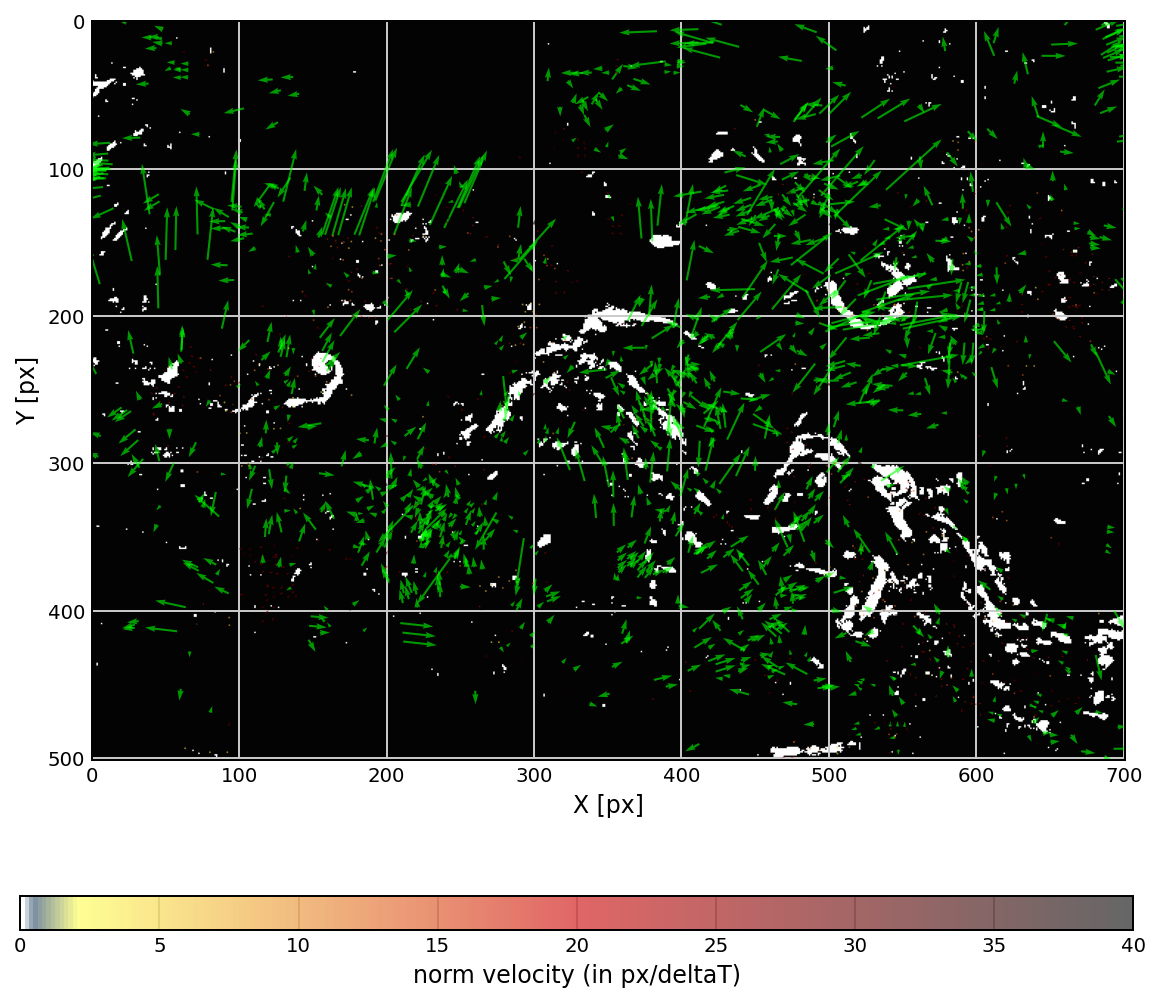

Flow vectors not generated.


SystemExit: [Warning] the following method should be run to produce an interpolated field that can be saved {extractGoodFeaturesPositionsDisplacementsAndInterpolate} or {extractGoodFeaturesDisplacementsAccumulateAndInterpolate}

/home/yahia/Documents/GitProjects/opyflow/opyfenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [46]:
# Binarized Antilles
if __name__ == "__main__":
    prev_nc = "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220723.nc"
    next_nc = "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220724.nc"
    lat_range = (12, 17)  
    lon_range = (-67, -60)
    
    flow_vectors = calculate_opyflow_with_temp_files(prev_nc, next_nc, variable_key="fai_anomaly", time_interval=86400, lat_range=lat_range, lon_range=lon_range)
    save_flow(prev_nc, output_path="/home/yahia/Documents/Jupyter/Sargassum/Images/Test/Opyflow.nc", flow_vectors=flow_vectors)

Dimensions :
 	 Width : 701 Height : 501
Regio Of Interest :
 	 [0, 0, 701, 501]

Good Features To Track Parameters:
	-  maxCorners : 40000
	-  qualityLevel : 0.005
	-  minDistance : 5
	-  blockSize : 16

Optical Flow Parameters:
	-  winSize : (16, 16)
	-  maxLevel : 3
	-  criteria : (3, 50, 0.03)

Filters Params:
	-  RadiusF : 30
	-  minNperRadius : 0
	-  maxDevInRadius : inf
	-  wayBackGoodFlag : inf
	-  CLAHE : False
	-  range_Vx : [-inf, inf]
	-  range_Vy : [-inf, inf]
	-  clplim : 3
	-  gridSize : (20, 20)

Interpolation Parameters:
	-  Radius : 30
	-  Sharpness : 8
	-  kernel : Gaussian

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]
number of frames : 2

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]

-------------- [Step 1 / 1

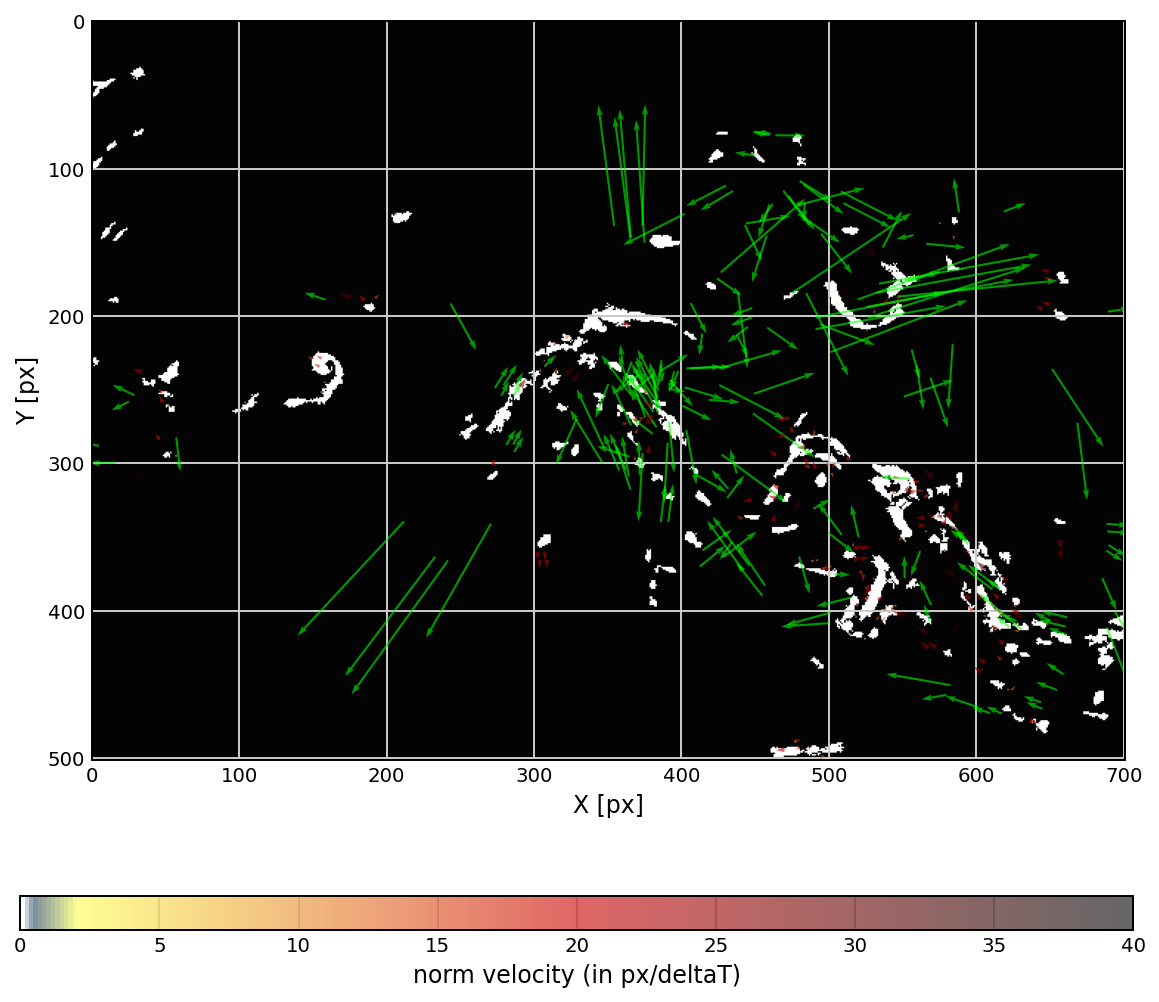

Flow vectors not generated.


SystemExit: [Warning] the following method should be run to produce an interpolated field that can be saved {extractGoodFeaturesPositionsDisplacementsAndInterpolate} or {extractGoodFeaturesDisplacementsAccumulateAndInterpolate}

In [50]:
# Filtered Antilles
if __name__ == "__main__":
    prev_nc = "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220723.nc"
    next_nc = "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220724.nc"
    lat_range = (12, 17)  
    lon_range = (-67, -60)
    
    flow_vectors = calculate_opyflow_with_temp_files(prev_nc, next_nc, variable_key="filtered", time_interval=86400, lat_range=lat_range, lon_range=lon_range)
    save_flow(prev_nc, output_path="/home/yahia/Documents/Jupyter/Sargassum/Images/Test/Opyflow.nc", flow_vectors=flow_vectors)

/tmp/ipykernel_34732/2082292674.py:25: RuntimeWarning: invalid value encountered in cast
  img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
/tmp/ipykernel_34732/2082292674.py:26: RuntimeWarning: invalid value encountered in cast
  img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


Dimensions :
 	 Width : 701 Height : 501
Regio Of Interest :
 	 [0, 0, 701, 501]

Good Features To Track Parameters:
	-  maxCorners : 40000
	-  qualityLevel : 0.005
	-  minDistance : 5
	-  blockSize : 16

Optical Flow Parameters:
	-  winSize : (16, 16)
	-  maxLevel : 3
	-  criteria : (3, 50, 0.03)

Filters Params:
	-  RadiusF : 30
	-  minNperRadius : 0
	-  maxDevInRadius : inf
	-  wayBackGoodFlag : inf
	-  CLAHE : False
	-  range_Vx : [-inf, inf]
	-  range_Vy : [-inf, inf]
	-  clplim : 3
	-  gridSize : (20, 20)

Interpolation Parameters:
	-  Radius : 30
	-  Sharpness : 8
	-  kernel : Gaussian

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]
number of frames : 2

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]

-------------- [Step 1 / 1

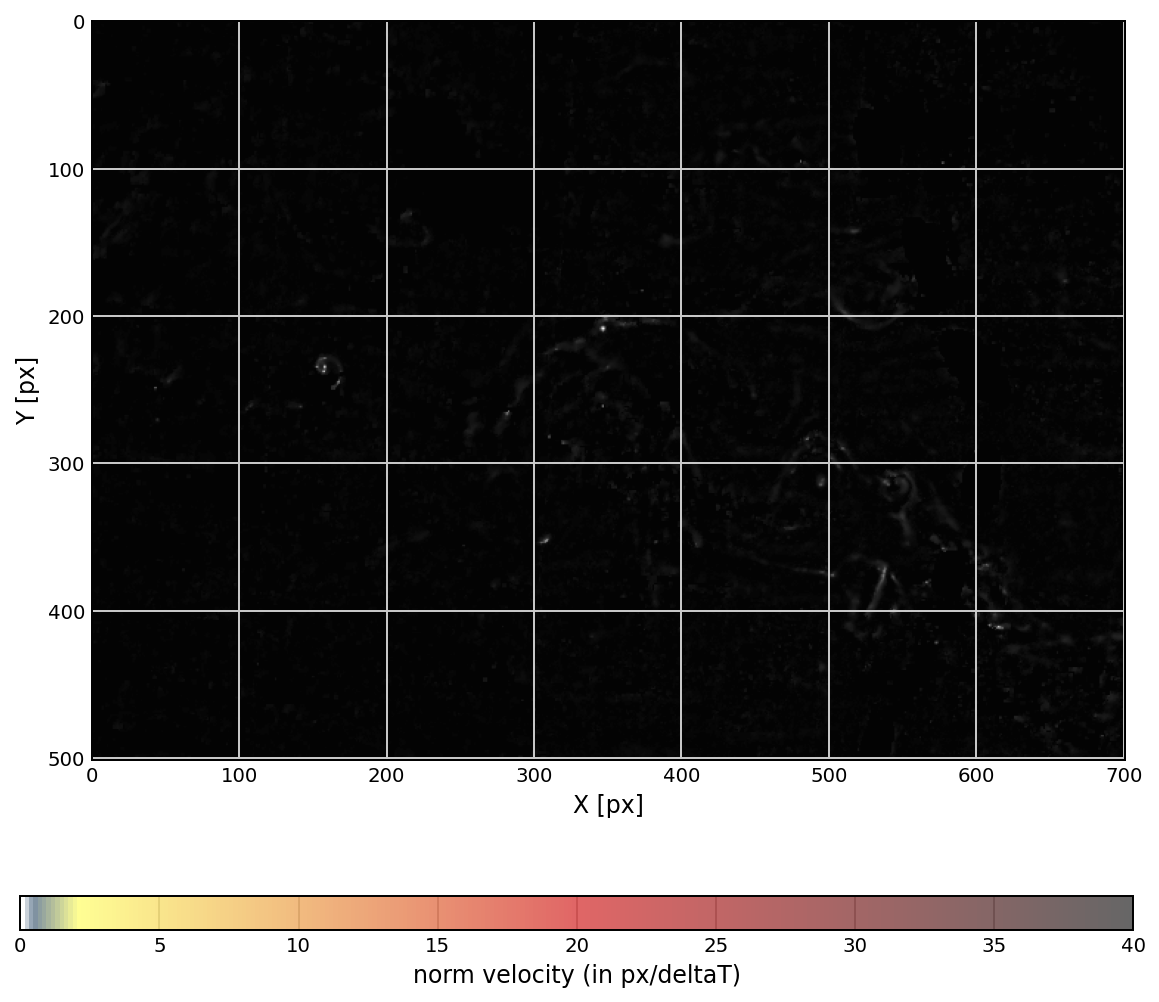

Flow vectors not generated.


In [28]:
# Antilles (Sub-Daily)
if __name__ == "__main__":
    prev_nc = "/home/yahia/Documents/Jupyter/Sargassum/Images/Sub-Daily/median_20220724_12-14.nc"
    next_nc = "/home/yahia/Documents/Jupyter/Sargassum/Images/Sub-Daily/median_20220724_14-16.nc"
    lat_range = (12, 17)  
    lon_range = (-67, -60)
    
    flow_vectors = calculate_opyflow_with_temp_files(prev_nc, next_nc, variable_key="fai_anomaly", time_interval=7200, lat_range=lat_range, lon_range=lon_range)
    # save_flow(prev_nc, output_path="/home/yahia/Documents/Jupyter/Sargassum/Images/Test/Opyflow.nc", flow_vectors=flow_vectors)

Dimensions :
 	 Width : 701 Height : 501
Regio Of Interest :
 	 [0, 0, 701, 501]

Good Features To Track Parameters:
	-  maxCorners : 40000
	-  qualityLevel : 0.005
	-  minDistance : 5
	-  blockSize : 16

Optical Flow Parameters:
	-  winSize : (16, 16)
	-  maxLevel : 3
	-  criteria : (3, 50, 0.03)

Filters Params:
	-  RadiusF : 30
	-  minNperRadius : 0
	-  maxDevInRadius : inf
	-  wayBackGoodFlag : inf
	-  CLAHE : False
	-  range_Vx : [-inf, inf]
	-  range_Vy : [-inf, inf]
	-  clplim : 3
	-  gridSize : (20, 20)

Interpolation Parameters:
	-  Radius : 30
	-  Sharpness : 8
	-  kernel : Gaussian

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]
number of frames : 2

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]

-------------- [Step 1 / 1

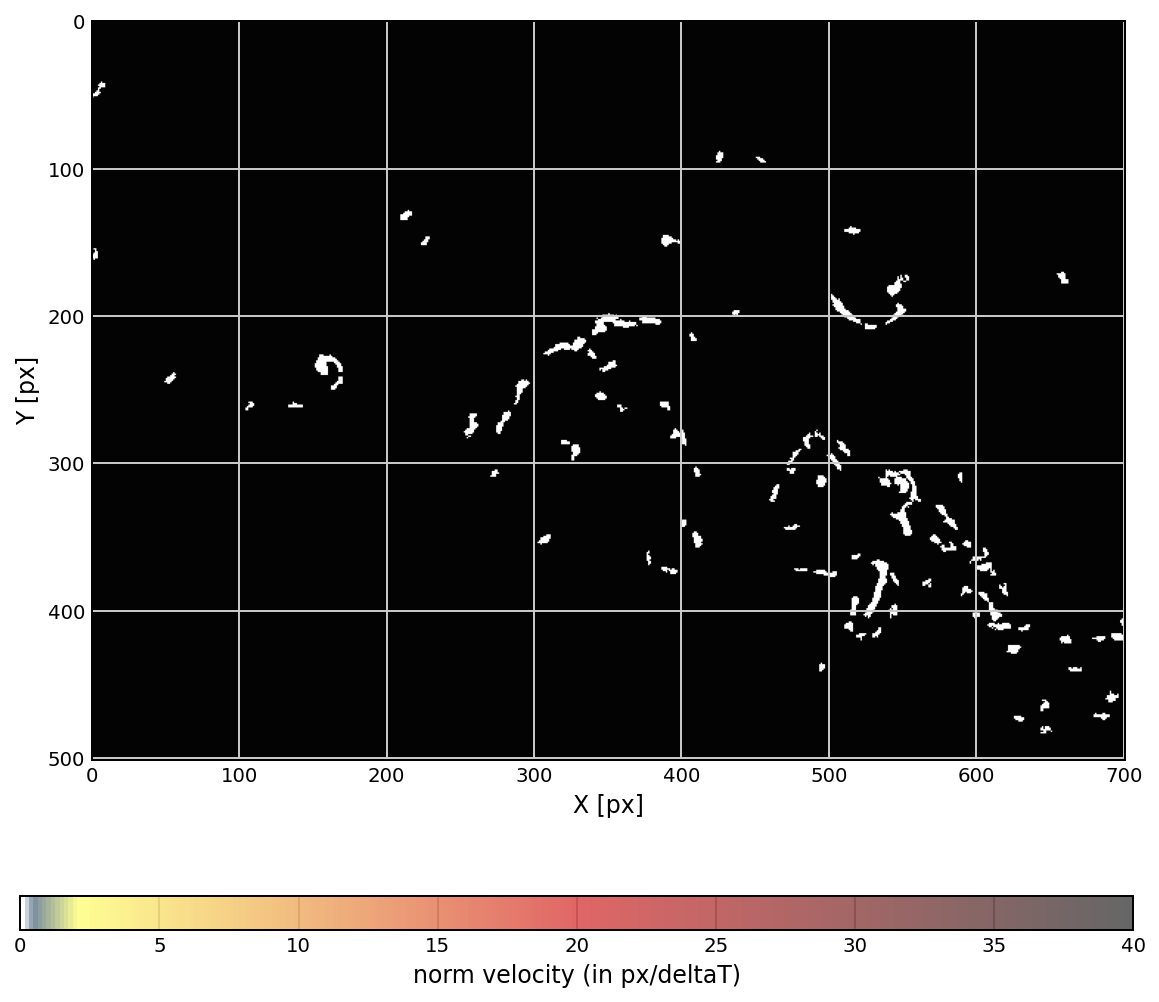

Flow vectors not generated.


In [29]:
# Filtered Antilles (Sub-Daily)
if __name__ == "__main__":
    prev_nc = "/home/yahia/Documents/Jupyter/Sargassum/Images/Sub-Daily/Binarized/Processed_median_20220724_12-14.nc"
    next_nc = "/home/yahia/Documents/Jupyter/Sargassum/Images/Sub-Daily/Binarized/Processed_median_20220724_14-16.nc"
    lat_range = (12, 17)  
    lon_range = (-67, -60)
    
    flow_vectors = calculate_opyflow_with_temp_files(prev_nc, next_nc, variable_key="fai_anomaly", time_interval=7200, lat_range=lat_range, lon_range=lon_range)
    # save_flow(prev_nc, output_path="/home/yahia/Documents/Jupyter/Sargassum/Images/Test/Opyflow.nc", flow_vectors=flow_vectors)

Dimensions :
 	 Width : 701 Height : 501
Regio Of Interest :
 	 [0, 0, 701, 501]

Good Features To Track Parameters:
	-  maxCorners : 40000
	-  qualityLevel : 0.005
	-  minDistance : 5
	-  blockSize : 16

Optical Flow Parameters:
	-  winSize : (16, 16)
	-  maxLevel : 3
	-  criteria : (3, 50, 0.03)

Filters Params:
	-  RadiusF : 30
	-  minNperRadius : 0
	-  maxDevInRadius : inf
	-  wayBackGoodFlag : inf
	-  CLAHE : False
	-  range_Vx : [-inf, inf]
	-  range_Vy : [-inf, inf]
	-  clplim : 3
	-  gridSize : (20, 20)

Interpolation Parameters:
	-  Radius : 30
	-  Sharpness : 8
	-  kernel : Gaussian

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]
number of frames : 2

[The following image processing plan has been set]
--> detect Good Features to Track on image [img1.png]
--> diplacements measurement between images [img1.png] and [img2.png]

-------------- [Step 1 / 1

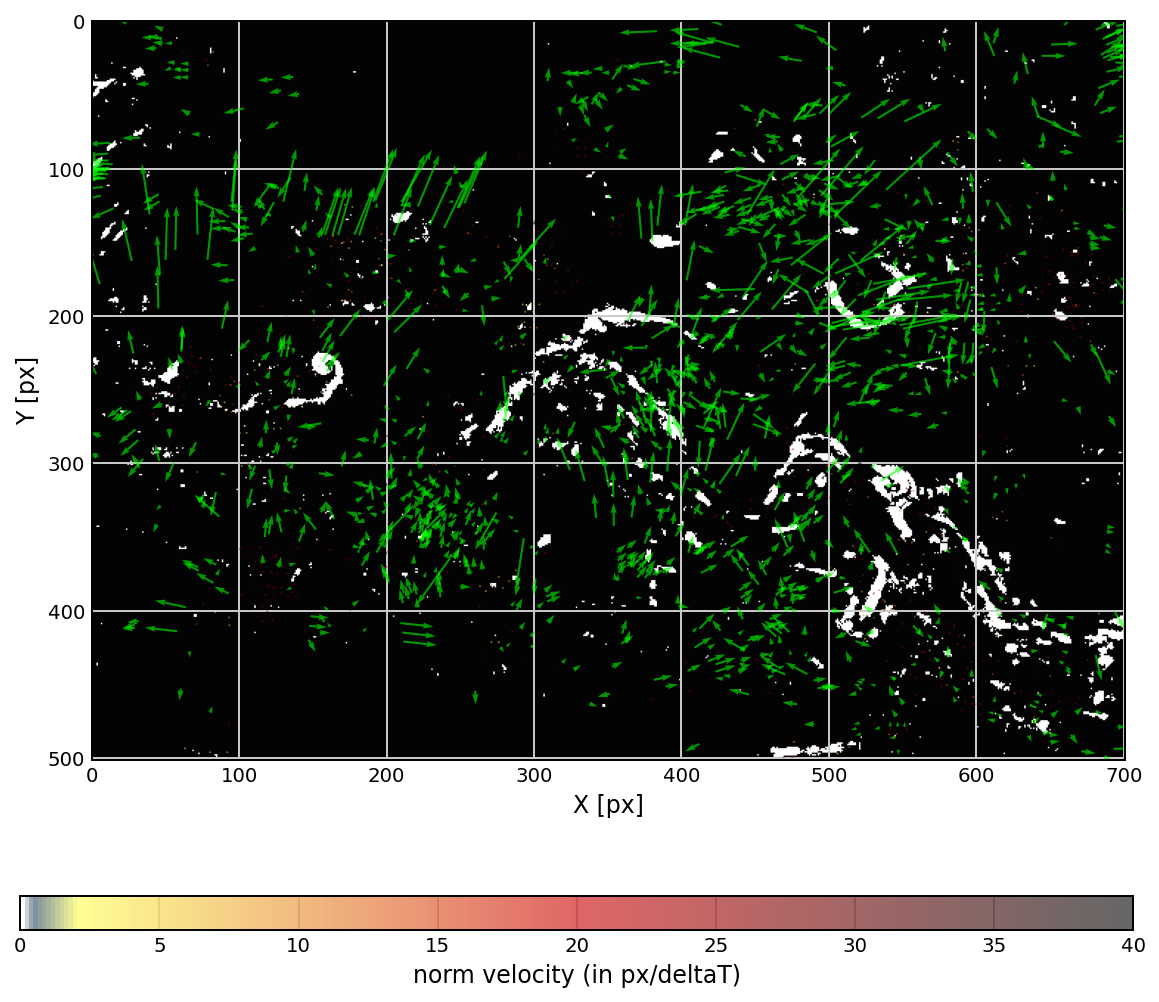

Flow vectors not generated.
Failed to calculate flow


In [32]:
import ipywidgets as widgets
from ipywidgets import interact

# Assuming the required functions and imports are already defined above
if __name__ == "__main__":
    prev_nc = "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220723.nc"
    next_nc = "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220724.nc"
    lat_range = (12, 17)  
    lon_range = (-67, -60)

    # Calculate flow vectors
    flow_vectors = calculate_opyflow_with_temp_files(prev_nc, next_nc, variable_key="fai_anomaly", time_interval=86400, lat_range=lat_range, lon_range=lon_range)
    if flow_vectors:
        flow_u_mps, flow_v_mps = flow_vectors
        
        # Define latitudes and longitudes for visualization
        latitudes = np.linspace(lat_range[0], lat_range[1], flow_u_mps.shape[0])
        longitudes = np.linspace(lon_range[0], lon_range[1], flow_u_mps.shape[1])
        
        # Save flow data to a file (optional)
        save_flow_data(flow_u_mps, flow_v_mps, latitudes, longitudes, filename="/home/yahia/Documents/Jupyter/Sargassum/Images/Test/Opyflow.nc")

        # Interactive visualization
        interactive_plot(flow_u_mps, flow_v_mps, latitudes, longitudes)
    else:
        print("Failed to calculate flow")

# Multiple Images

## *process_multiple_images*

In [47]:
def process_multiple_images(nc_files, variable_key="fai_anomaly", lat_range=None, lon_range=None):
    images_dir = tempfile.TemporaryDirectory()

    # Load and preprocess each NetCDF file
    for idx, nc_file in enumerate(nc_files):
        data = xr.open_dataset(nc_file)
        if lat_range and 'latitude' in data.coords:
            data = data.sel(latitude=slice(*lat_range))
        if lon_range and 'longitude' in data.coords:
            data = data.sel(longitude=slice(*lon_range))
        
        img = data[variable_key].values
        if img.ndim == 3:
            img = img[0]
        
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img = cv2.flip(img, 0)
        cv2.imwrite(os.path.join(images_dir.name, f'image_{idx:03d}.png'), img)

    # Setup the analyzer for the sequence of images
    analyzer = opyf.frameSequenceAnalyzer(images_dir.name)
    analyzer.set_vecTime(starting_frame=0, step=1, shift=1, Ntot=len(nc_files)-1)

    # Extract features and displacements for the sequence
    try:
        analyzer.extractGoodFeaturesAndDisplacements(display='quiver', displayColor=True, width=0.002)
        if hasattr(analyzer, 'flow_vectors'):
            flow_vectors = analyzer.flow_vectors
            print("Flow vectors generated.")
            return flow_vectors
        else:
            print("Flow vectors not generated.")
            return None
    except Exception as e:
        print(f"Error during feature extraction: {e}")
        return None
    finally:
        images_dir.cleanup()  # Ensure temporary directory is cleaned up

Dimensions :
 	 Width : 701 Height : 501
Regio Of Interest :
 	 [0, 0, 701, 501]

Good Features To Track Parameters:
	-  maxCorners : 40000
	-  qualityLevel : 0.005
	-  minDistance : 5
	-  blockSize : 16

Optical Flow Parameters:
	-  winSize : (16, 16)
	-  maxLevel : 3
	-  criteria : (3, 50, 0.03)

Filters Params:
	-  RadiusF : 30
	-  minNperRadius : 0
	-  maxDevInRadius : inf
	-  wayBackGoodFlag : inf
	-  CLAHE : False
	-  range_Vx : [-inf, inf]
	-  range_Vy : [-inf, inf]
	-  clplim : 3
	-  gridSize : (20, 20)

Interpolation Parameters:
	-  Radius : 30
	-  Sharpness : 8
	-  kernel : Gaussian

[The following image processing plan has been set]
--> detect Good Features to Track on image [image_000.png]
--> diplacements measurement between images [image_000.png] and [image_001.png]
number of frames : 8

[The following image processing plan has been set]
--> detect Good Features to Track on image [image_000.png]
--> diplacements measurement between images [image_000.png] and [image_001.pn

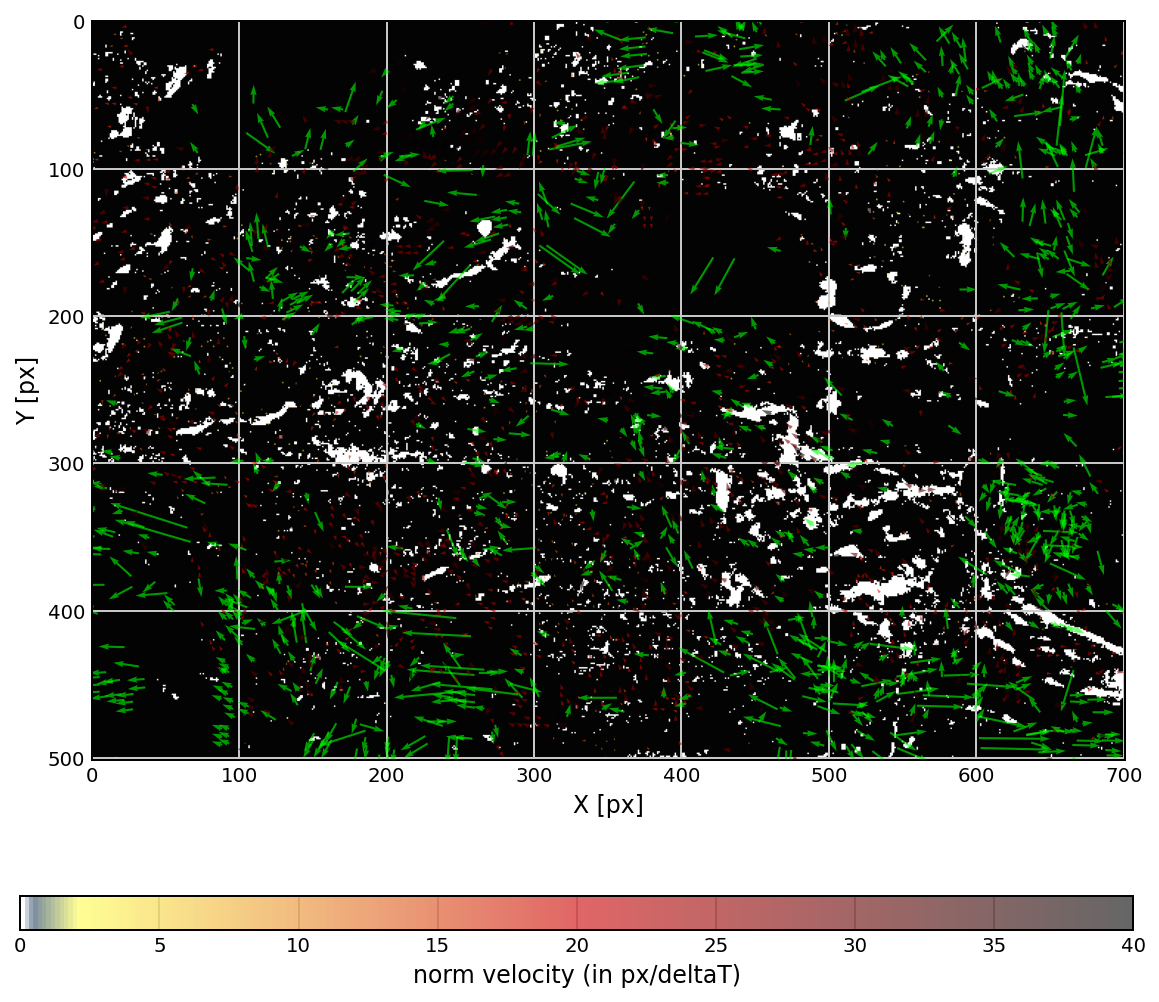


-------------- [Step 2 / 7] --------------
------- From frame [image_001.png] to frame [image_002.png] -------
Number of Good Feature To Track = 4005
Displacement max = 753.28345 px/deltaT
only 3000vectors ave been plotted because the number of velocity vectors is >3000


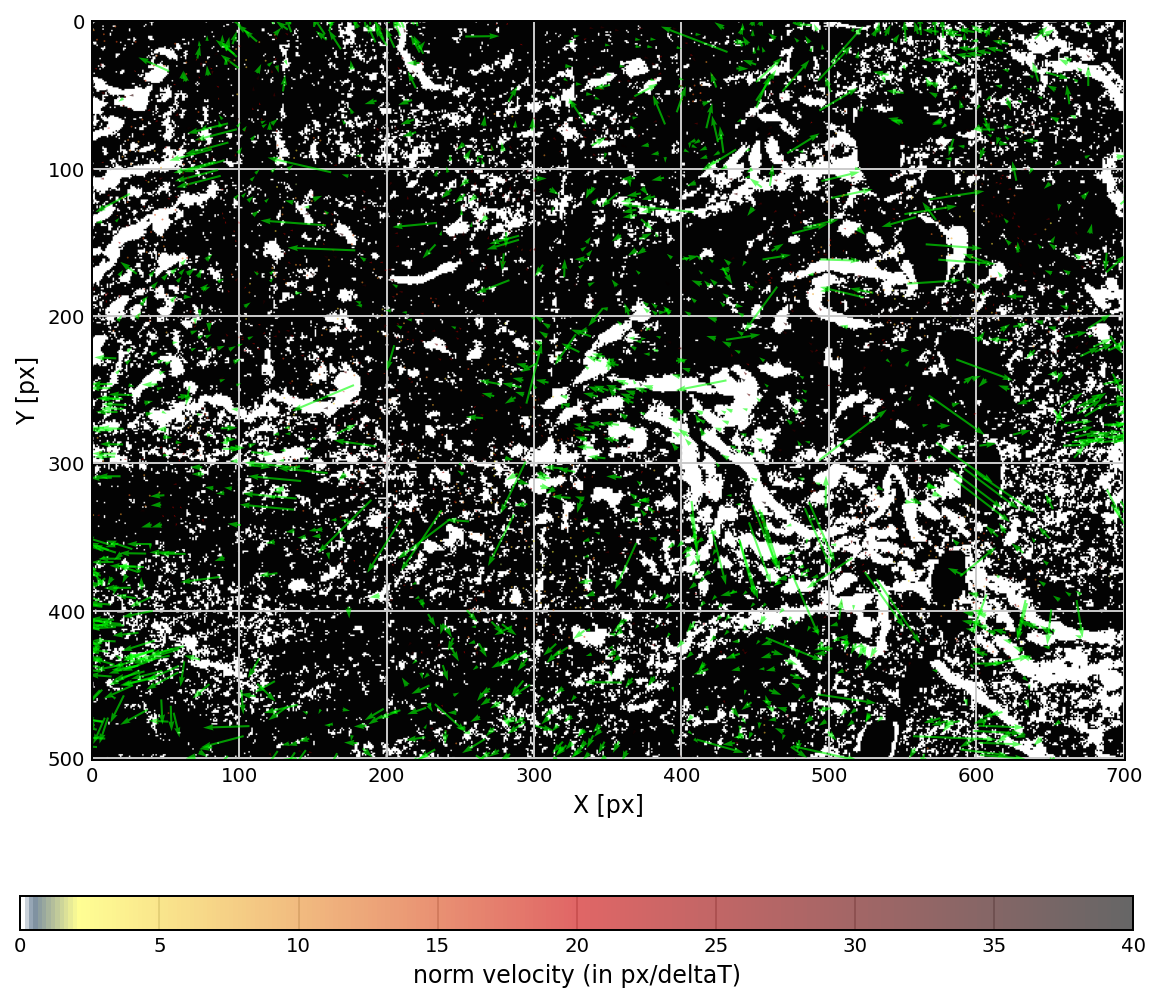


-------------- [Step 3 / 7] --------------
------- From frame [image_002.png] to frame [image_003.png] -------
Number of Good Feature To Track = 3643
Displacement max = 694.26965 px/deltaT
only 3000vectors ave been plotted because the number of velocity vectors is >3000


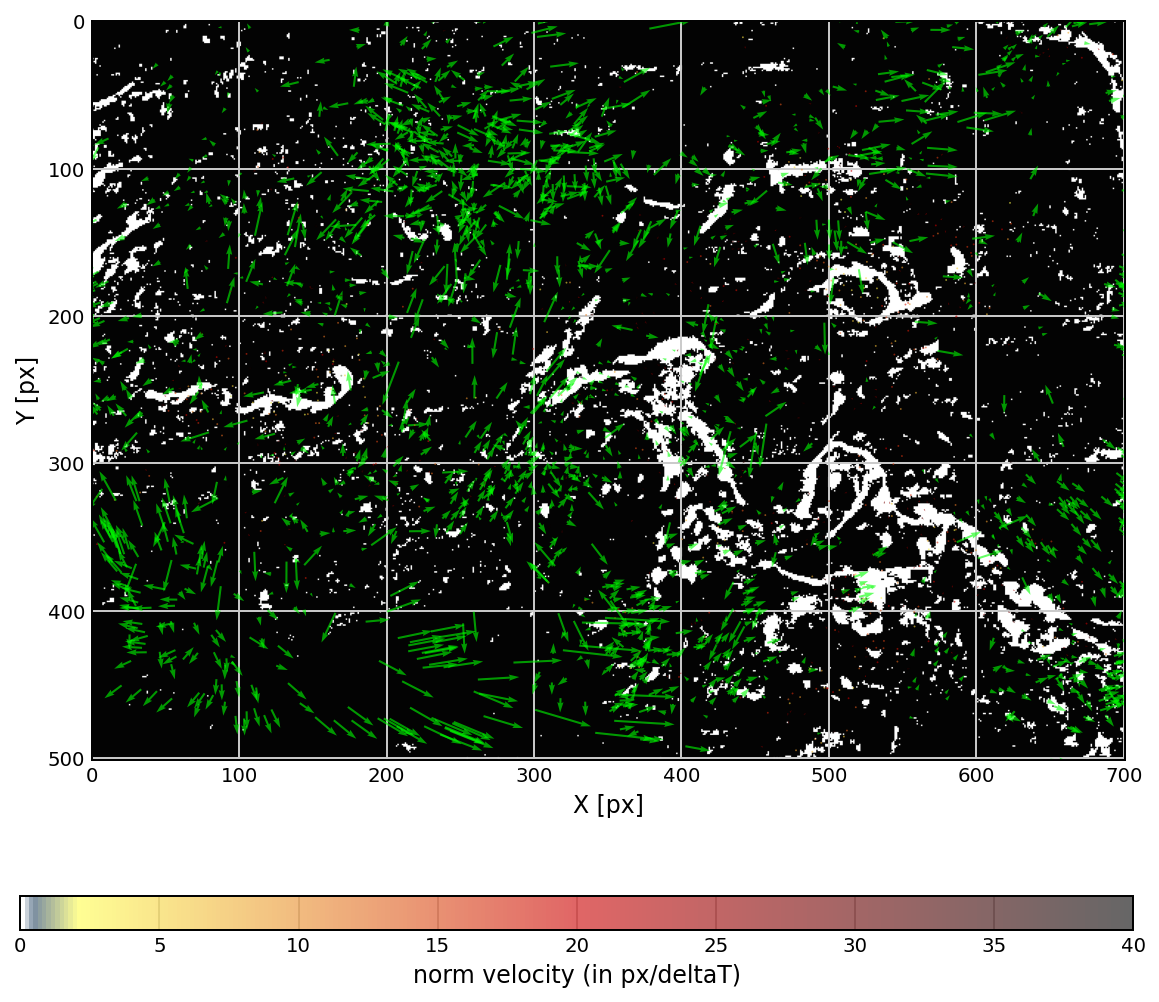


-------------- [Step 4 / 7] --------------
------- From frame [image_003.png] to frame [image_004.png] -------
Number of Good Feature To Track = 2448
Displacement max = 444.46075 px/deltaT


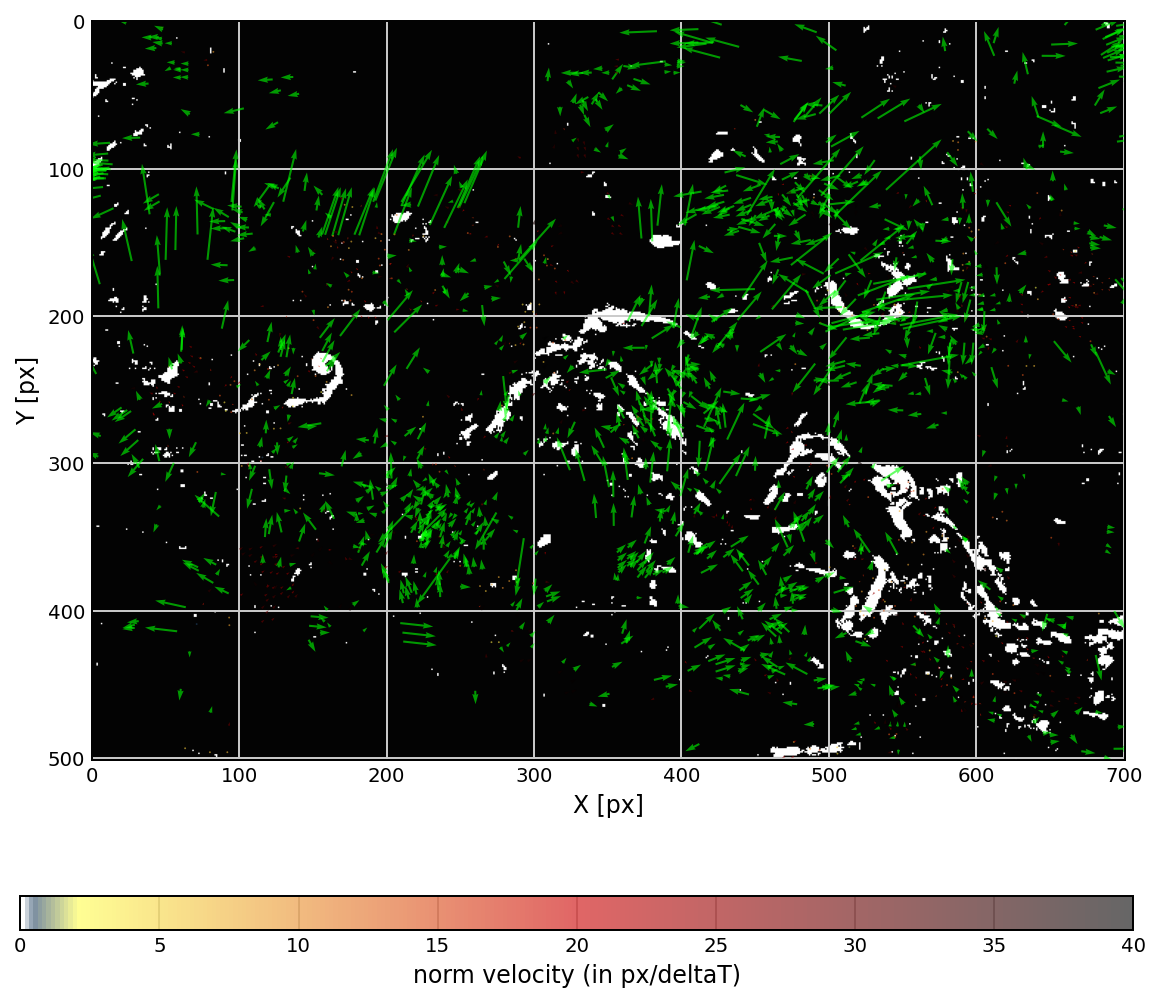


-------------- [Step 5 / 7] --------------
------- From frame [image_004.png] to frame [image_005.png] -------
Number of Good Feature To Track = 3019
Displacement max = 374.5055 px/deltaT
only 3000vectors ave been plotted because the number of velocity vectors is >3000


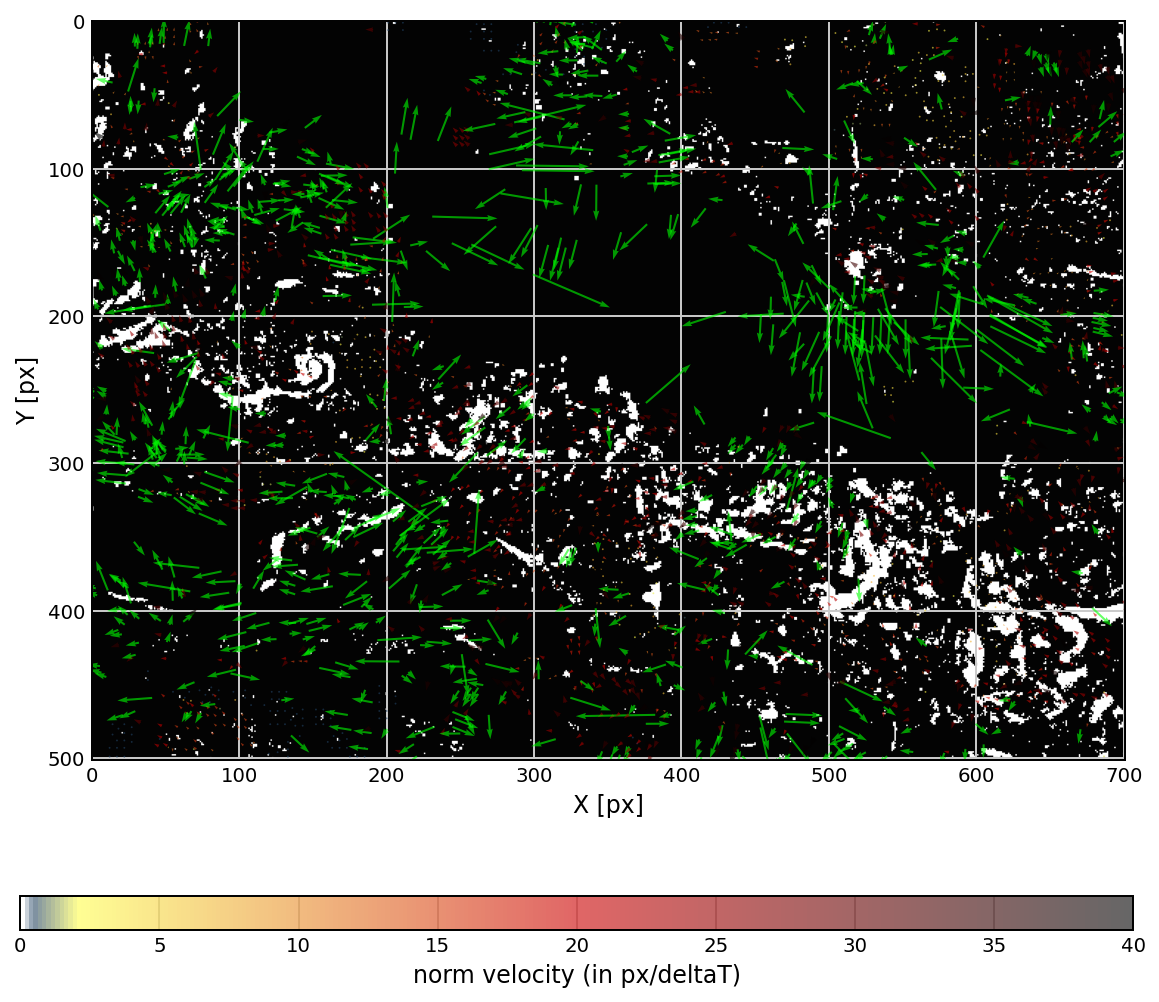


-------------- [Step 6 / 7] --------------
------- From frame [image_005.png] to frame [image_006.png] -------
Number of Good Feature To Track = 3026
Displacement max = 667.85266 px/deltaT
only 3000vectors ave been plotted because the number of velocity vectors is >3000


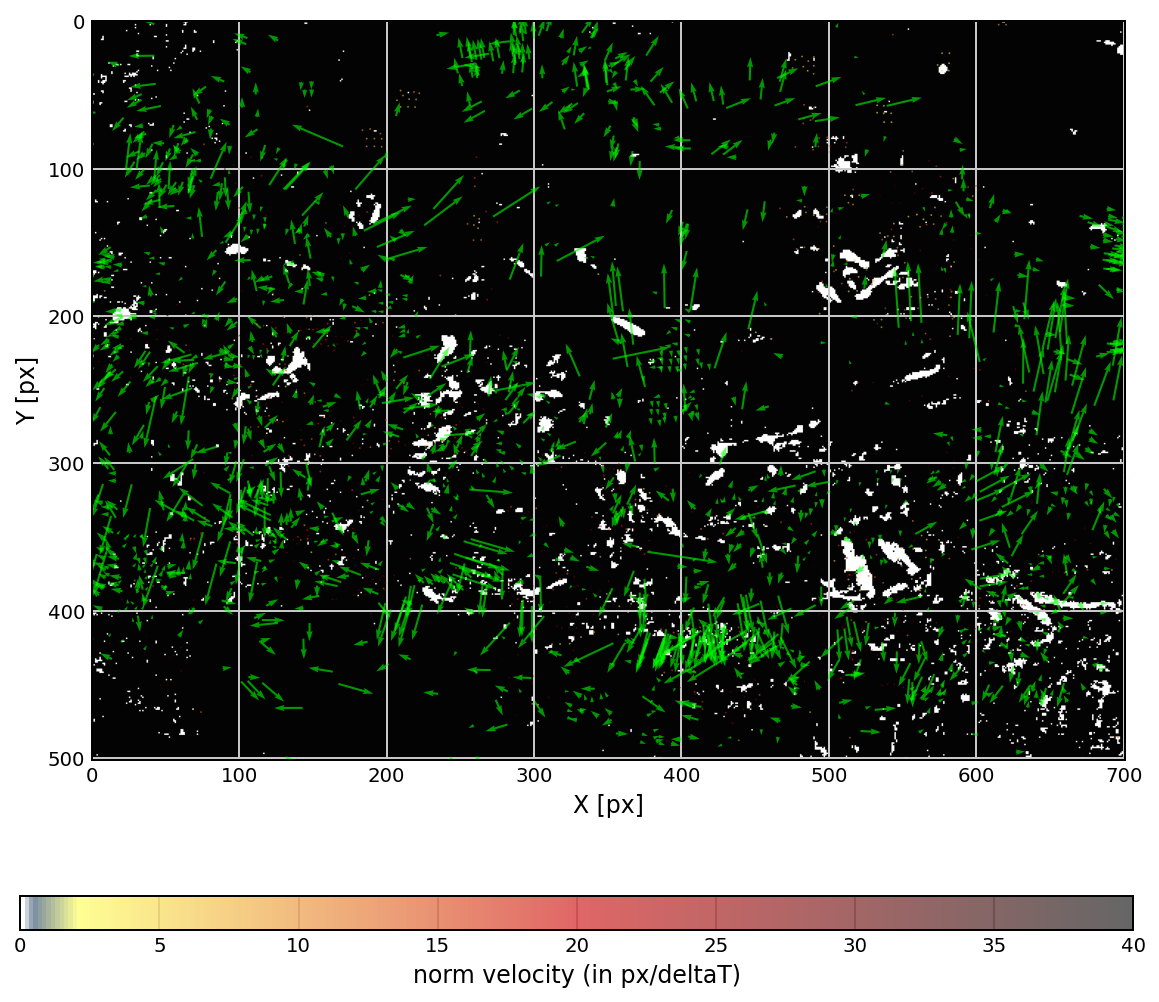


-------------- [Step 7 / 7] --------------
------- From frame [image_006.png] to frame [image_007.png] -------
Number of Good Feature To Track = 3545
Displacement max = 419.68115 px/deltaT
only 3000vectors ave been plotted because the number of velocity vectors is >3000


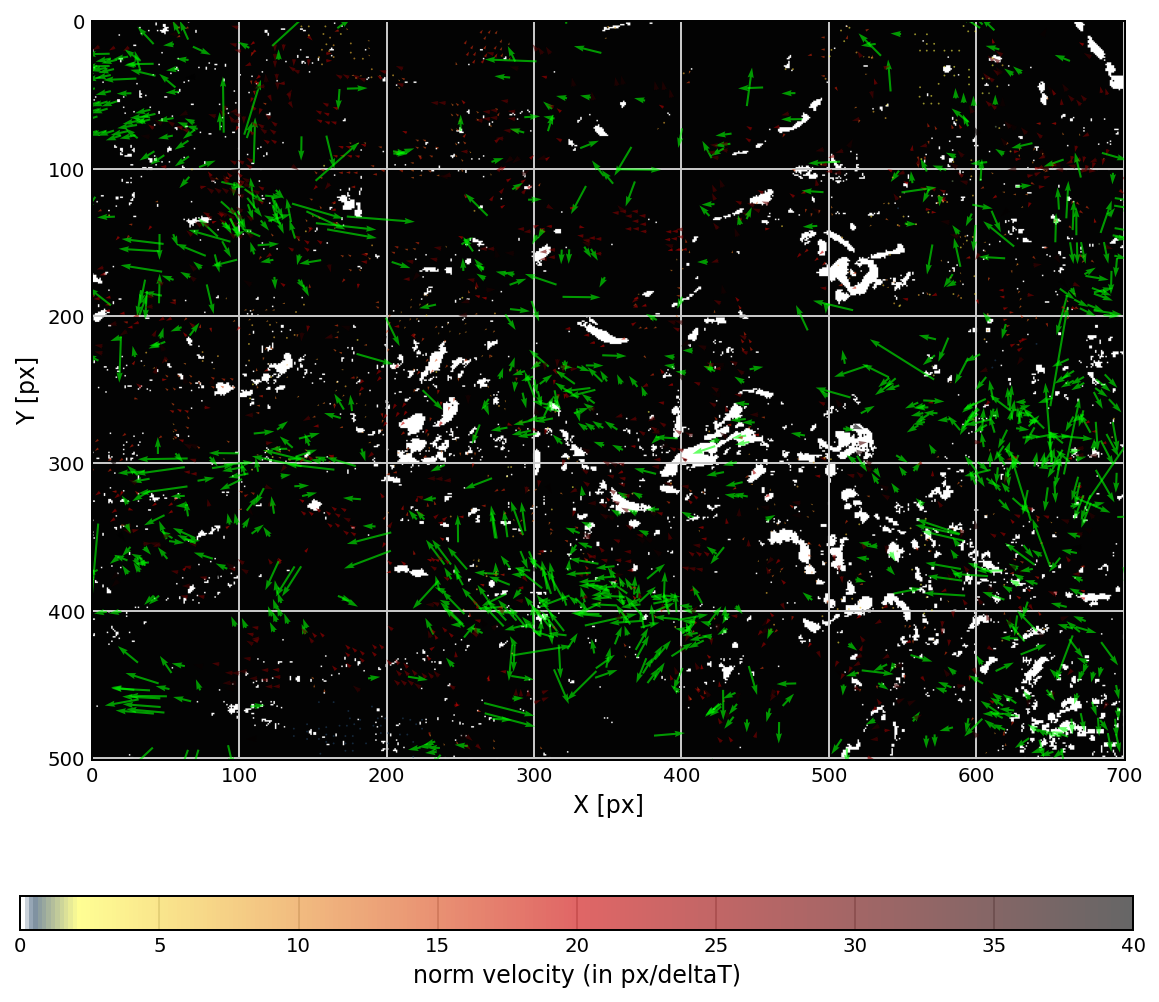

Flow vectors not generated.


In [53]:
if __name__ == "__main__":
    nc_files = [
    "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220720.nc",
    "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220721.nc",
    "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220722.nc",
    "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220723.nc",
    "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220724.nc",
    "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220725.nc",
    "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220726.nc",
    "/media/yahia/ballena/ABI/NetCDF/Atlantic/Filtered/Filtered_algae_distribution_20220727.nc"
    ]
    flow_vectors = process_multiple_images(nc_files, variable_key="fai_anomaly", lat_range=(12, 17), lon_range=(-67, -60))